In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.rcParams['font.sans-serif'] = "Calibri"
# mpl.rcParams['font.size'] = 6
plt.rc('font',family='Arial',size=8)
# Setting mathfont-------------------------------------
from matplotlib import rcParams
config = {"mathtext.fontset":'stix',}
rcParams.update(config)
# -----------------------------------------------------
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
import matplotlib.patches as patches
import os
import math 
from scipy import ndimage
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator 
import matplotlib.dates as mdates
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader
from pylab import *
import time
import datetime
from scipy import interpolate
import metpy.calc as mpcalc
from metpy.units import units
from skimage import transform
from scipy.stats.mstats import ttest_ind
import cmaps 
plt.close() 

# 1. Prepare data

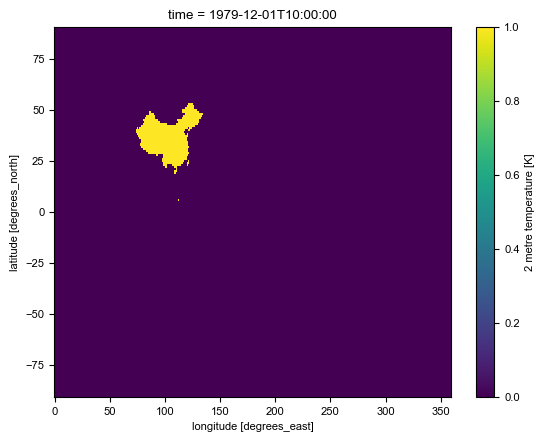

In [9]:
'''
------------------------------------------------------
Prepare 2m temperature data
------------------------------------------------------
'''
from osgeo import gdal,osr,ogr
def makeMask(lon,lat,res,shapefile):
    source_ds = ogr.Open(shapefile)
    source_layer = source_ds.GetLayer()
 
    # Create high res raster in memory
    mem_ds = gdal.GetDriverByName('MEM').Create('', lon.size, lat.size, gdal.GDT_Byte)
    mem_ds.SetGeoTransform((lon.min(), res, 0, lat.max(), 0, -res)) # The latitude should be sorted in descending order
    band = mem_ds.GetRasterBand(1)
 
    # Rasterize shapefile to grid
    gdal.RasterizeLayer(mem_ds, [1], source_layer, burn_values=[1])
 
    # Get rasterized shapefile as numpy array
    array = band.ReadAsArray()
 
    # Flush memory file
    mem_ds = None
    band = None
    return array


# Read 2m temeprature from 1979 to 2023
input_dir = '../data/era5_single-level/2m_temperature'
files_ls = [f'{input_dir}/era5_single_2m_temperature_{year}.nc' for year in np.arange(1979,2024,1)]
ds = xr.open_mfdataset(files_ls)
t2m_Dec_1979to2023 = ds['t2m'].sel(time=ds['time.month'].isin([12])).compute()

# Make the China mask
shapefile = '../data/China-province/China-province.shp'
longitude = t2m_Dec_1979to2023['longitude']
latitude = t2m_Dec_1979to2023['latitude']
cellsize = 1
china_mask = makeMask(longitude,latitude,cellsize,shapefile)
china_mask_xr = xr.zeros_like(t2m_Dec_1979to2023[0,:,:], dtype=float32).rename('mask')
china_mask_xr.values = china_mask
china_mask_xr.plot()

# Calculate the temperature averaged over China
weights = np.cos(np.deg2rad(t2m_Dec_1979to2023['latitude']))
t2m_Dec_1979to2023_China = t2m_Dec_1979to2023.where(china_mask_xr==1).weighted(weights).mean('latitude').mean('longitude')
t2m_Dec_1979to2023_China_mean = np.reshape(t2m_Dec_1979to2023_China.values, (45,31)).mean(axis=0)
t2m_Dec_1979to2023_China_std = np.reshape(t2m_Dec_1979to2023_China.values, (45,31)).std(axis=0)
t2m_NormAno_Dec_2023 = (t2m_Dec_1979to2023_China.loc['2023-12-01':'2023-12-31']-t2m_Dec_1979to2023_China_mean) / t2m_Dec_1979to2023_China_std
t2m_std_1979to2023 = np.reshape(t2m_Dec_1979to2023_China.values-237.15, (45,31)).std(axis=1)

In [4]:
'''
------------------------------------------------------
Prepare t2m_diff data
------------------------------------------------------
'''
# Read data
input_dir = '../data/era5_single-level/2m_temperature'
files_ls = [f'{input_dir}/era5_single_2m_temperature_{year}.nc' for year in np.arange(1979,2024,1)]
ds = xr.open_mfdataset(files_ls)
t2m_1979to2021 = ds['t2m']
t2m_1979to2021_no_feb29 = t2m_1979to2021.sel(time=~((t2m_1979to2021['time.month'] == 2) & (t2m_1979to2021['time.day'] == 29)))
t2m_1979to2021_NDJFM = t2m_1979to2021_no_feb29.sel(time=t2m_1979to2021_no_feb29['time.month'].isin([10,11,12,1,2])).loc['1979-10-01':'2023-02-28']

# Calculate T2m_diff between 72 hours
interval_hour = 72
time_array = t2m_1979to2021_NDJFM['time']
new_time_array = time_array - pd.Timedelta(hours=interval_hour)
t2m_1979to2021_NDJFM_neg72 = t2m_1979to2021_no_feb29.sel(time=new_time_array)
t2m_diff_1979to2021_NDJFM = t2m_1979to2021_NDJFM - t2m_1979to2021_NDJFM_neg72.values

# Select 1979to2021DJF data
data = t2m_diff_1979to2021_NDJFM.sel(time=t2m_diff_1979to2021_NDJFM['time.month'].isin([12,1,2])).compute()
P05 = data.quantile(0.05, dim='time')

In [6]:
'''
------------------------------------------------------
Prepare Corr data
------------------------------------------------------
'''
ds = xr.open_dataset('../data/Norm-Cauchy_Res/Norm-Cauchy_Res_72-hour.nc')
Norm_corr = ds['Norm_corr']
Norm_pvalue = ds['Norm_p-value']
Cauchy_corr = ds['Cauchy_corr']
Cauchy_pvalue = ds['Cauchy_p-value']


In [7]:
'''
------------------------------------------------------
Prepare trend of WWEs
------------------------------------------------------
'''

ds3 = xr.open_dataset('../data/AR6_region_TREND/AR6_Region_TREND_72-hour.nc')
cold_WWEs_trend_ar6_2_day = ds3['cold_WWEs_trend']
cold_WWEs_p_value_ar6_2_day = ds3['cold_WWEs_p_value']

import regionmask
ar6_land = regionmask.defined_regions.ar6.land
land_50 = regionmask.defined_regions.natural_earth_v5_1_2.land_50
land_mask = xr.where(land_50.mask(cold_WWEs_trend_ar6_2_day)==0,1,0)    # land --> 1
                                                                        # sea --> 0

# 2. Visualize the data

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np



data_ccrs = ccrs.PlateCarree() 
fig, axs = plt.subplots(2, 2, figsize=(9*1.1,5*1.1), dpi=1000)



'''
-------------------------------------------------------------------------------------- 
ax = axs[0,0]
-------------------------------------------------------------------------------------- 
'''
ax = axs[0,0]
ax.axis('off')
col_shift = 0.15
inset_ax1 = ax.inset_axes([0.05, 0+2*col_shift, 0.7, 1-2*col_shift])  # 左侧子图居中
inset_ax2 = ax.inset_axes([0.85, 0+2*col_shift, 0.1, 1-2*col_shift])  # 右侧子图居中

# -------------------------------------------------------------------------------------- 
# inset_ax1 
# -------------------------------------------------------------------------------------- 
x_ticks = t2m_Dec_1979to2023_China.loc['2023-12-01':'2023-12-31']['time']
for each in range(44):
    inset_ax1.plot(x_ticks, t2m_Dec_1979to2023_China[int(each*31):int(each*31)+31].values-273.15, linewidth=0.6, alpha=0.5, color='gray', label=r'$\mathbf{T_{2m}\; in\; 1979–2022}$', zorder=3)
line1, = inset_ax1.plot(x_ticks, t2m_Dec_1979to2023_China.loc['2023-12-01':'2023-12-31']-273.15, linewidth=0.6, alpha=0.5, color='gray', label=r'$\mathbf{T_{2m}\; in\; 1979–2022}$', zorder=3)
line2, = inset_ax1.plot(x_ticks, t2m_Dec_1979to2023_China.loc['2023-12-01':'2023-12-31']-273.15, linewidth=3, color='purple', label=r'$\mathbf{T_{2m}\; in\; 2023}$', zorder=7)
line3, = inset_ax1.plot(x_ticks, t2m_Dec_1979to2023_China_mean-273.15, linewidth=4, color='black', label=r'$\mathbf{T_{2m}\; in\; clim}$', zorder=5)


inset_ax1.plot(x_ticks, t2m_Dec_1979to2023_China.where(t2m_NormAno_Dec_2023>=1.5)-273.15, 
        linewidth=7.5, alpha=0.6, color='tab:red', zorder=7)
inset_ax1.plot(x_ticks, t2m_Dec_1979to2023_China.where(t2m_NormAno_Dec_2023<=-1.5)-273.15, 
        linewidth=7.5, alpha=0.6, color='tab:blue', zorder=7)

inset_ax1.set_xticks(x_ticks[::5])
inset_ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
inset_ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
inset_ax1.set_xlabel('Date (mm/dd)')

inset_ax1.set_ylim(-18,0)
inset_ax1.set_yticks(np.linspace(-18,0,5))
inset_ax1.set_ylabel('Temperature (°C)')

inset_ax1.grid(True, linewidth=0.3, linestyle='--')
inset_ax1.set_title('(a)', loc='left')

# -------------------------------------------------------------------------------------- 
# inset_ax2
# -------------------------------------------------------------------------------------- 
inset_ax2.scatter(np.ones_like(t2m_std_1979to2023), np.power(t2m_std_1979to2023,2), 
           facecolor='none', edgecolor='gray', marker='D', linewidth=0.8, s=20, alpha=0.8, zorder=5)
inset_ax2.scatter(1, np.power(t2m_std_1979to2023[-1],2), 
           facecolor='purple', edgecolor='none', marker='D', linewidth=0.8, s=20, alpha=1, zorder=3)
inset_ax2.set_xlim(0.5,1.5)
inset_ax2.set_xticks([1])
inset_ax2.set_xticklabels(['1979–2023'])
inset_ax2.set_xlim(0.5,1.5)
inset_ax2.set_ylim(0,15)
inset_ax2.set_yticks(np.linspace(0,15,6))
inset_ax2.set_ylabel('Intra-monthly variance (°C^2)', labelpad=1.5)

inset_ax2.set_title('(b)', loc='left')

# -------------------------------------------------------------------------------------- 
# ax_legend
# -------------------------------------------------------------------------------------- 
ax_legend = ax.inset_axes([0,-0.025,0.7,0.3])
ax_legend.axis('off')
legend = ax_legend.legend(handles=[line1,line2,line3], loc='lower center', fontsize=9, ncol=3,  bbox_to_anchor=(0.675, 0.07))
legend.get_frame().set_alpha(0)



'''
-------------------------------------------------------------------------------------- 
ax = axs[1,0]
-------------------------------------------------------------------------------------- 
'''
ax = axs[1,0]
ax.axis('off')
##Some attrs of map##
ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw=0.5, edgecolor='black') 
ax.gridlines(xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90,91,30), linewidth=0.3, ls='--')
##x-axis##
dlon = 60
xticks = np.arange(-180, 180.1, dlon)
ax.set_xticks(xticks, crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter())  
##y-axis##
dlat = 30
yticks = np.arange(-90, 90.1, dlat)   
ax.set_yticks(yticks, crs=ccrs.PlateCarree()) 
ax.yaxis.set_major_formatter(LatitudeFormatter())   
ax.set_ylim(-60,90)
##Contourf##
corr_cyclic, lon_cyclic = add_cyclic_point(Norm_corr.where(Norm_pvalue<0.05), coord=Norm_corr['longitude'])
ax_con = ax.contourf(lon_cyclic, Norm_corr['latitude'], corr_cyclic,
            levels=np.linspace(0.95,1,11), extend='both', cmap=cmaps.MPL_Purples_r, transform=data_ccrs)
cb = fig.colorbar(ax_con, ax=ax, orientation='horizontal', spacing='proportional',
            drawedges=False, shrink=0.7, aspect=35)
cb.ax.tick_params(axis='both', length=0)
cb.outline.set_visible(True)
cb.outline.set_linewidth(0.3) 
cb.set_label('Correlation coefficient')
ax.set_title('(c) Corr KDE&Gaussian', loc='left')
ax.set_title('Time interval: 72h', loc='right')



'''
-------------------------------------------------------------------------------------- 
ax = axs[0,1]
-------------------------------------------------------------------------------------- 
'''
ax = axs[0,1]
ax.axis('off')
##Some attrs of map##
ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw=0.5, edgecolor='black') 
ax.gridlines(xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90,91,30), linewidth=0.3, ls='--')
##x-axis##
dlon = 60
xticks = np.arange(-180, 180.1, dlon)
ax.set_xticks(xticks, crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter())  
##y-axis##
dlat = 30
yticks = np.arange(-90, 90.1, dlat)   
ax.set_yticks(yticks, crs=ccrs.PlateCarree()) 
ax.yaxis.set_major_formatter(LatitudeFormatter())   #将数字设置为纬度格式
ax.set_ylim(-60,90)
##Contourf##
var_contour, lon_cyclic = add_cyclic_point(P05, coord=P05['longitude'])
ax_trend = ax.contourf(lon_cyclic, P05['latitude'], var_contour,\
                        levels=np.linspace(-14,0,8), extend='both', cmap=cmaps.MPL_Purples_r, transform=data_ccrs)
cb = fig.colorbar(ax_trend, ax=ax, orientation='horizontal', spacing='proportional',
                drawedges=False, shrink=0.7, aspect=35)
cb.ax.tick_params(axis='both', length=0)
cb.outline.set_visible(True)
cb.outline.set_linewidth(0.3) 
cb.set_label('unit: K')
ax.set_title('(d) P05', loc='left')
ax.set_title('Time interval: 72h', loc='right')



'''
-------------------------------------------------------------------------------------- 
ax = axs[1,1]
-------------------------------------------------------------------------------------- 
'''
ax = axs[1,1]
ax.axis('off')
##Some attrs of map##
ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw=0.5, edgecolor='black') 
# ax.gridlines(xlocs=np.arange(-180, 181, 60), ylocs=np.arange(-90,91,30), linewidth=0.3, ls='--')
##x-axis##
dlon = 60
xticks = np.arange(-180, 180.1, dlon)
ax.set_xticks(xticks, crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter())  
##y-axis##
dlat = 30
yticks = np.arange(-90, 90.1, dlat)   
ax.set_yticks(yticks, crs=ccrs.PlateCarree()) 
ax.yaxis.set_major_formatter(LatitudeFormatter())   #将数字设置为纬度格式
ax.set_ylim(-60,90)
### pcolormesh ###
var_contour, lon_cyclic = add_cyclic_point(cold_WWEs_trend_ar6_2_day.where(land_mask==1), coord=cold_WWEs_trend_ar6_2_day['lon'])
ax_trend = ax.contourf(lon_cyclic, cold_WWEs_trend_ar6_2_day['lat'], var_contour, cmap=cmaps.MPL_RdBu, 
                        levels=np.linspace(-0.09,0.09,7), transform=data_ccrs)
### Colorbar ###
cb = fig.colorbar(ax_trend, ax=ax, orientation='horizontal', spacing='proportional',
                    drawedges=False, shrink=0.7, aspect=35)
cb.ax.tick_params(axis='both', length=0)
cb.outline.set_visible(True)
cb.outline.set_linewidth(0.3) 
cb.set_label('unit: num/year')
### significant level ###
mpl.rcParams['hatch.linewidth'] = 0.5
mpl.rcParams['hatch.color'] = 'black'
ax.contourf(cold_WWEs_p_value_ar6_2_day['lon'], cold_WWEs_p_value_ar6_2_day['lat'], cold_WWEs_p_value_ar6_2_day.where(land_mask==1),
            levels=[0,0.05,1], hatches=['/////',None], alpha=0, transform=data_ccrs)
### AR6 region ###
ar6_land.plot(ax=ax, label='abbrev', add_coastlines=None, line_kws=dict(linewidth=0.5), text_kws=dict(fontsize=5,backgroundcolor='None',fontweight='bold'), projection=data_ccrs)
ax.set_title('(e) Trend of flash-cold days in DJF', loc='left')
ax.set_title('Time interval: 72h', loc='right')


plt.tight_layout()
plt.savefig(f'figure-1.jpg', bbox_inches='tight')
plt.show()


/data3/users/2022chenhy/ansoftware/anaconda3/lib/python3.9/site-packages/cmaps/cmaps.py:1771: UserWarning: Overwriting the cmap 'MPL_Purples_r' that was already in the registry.
  register_cmap(name=cname, cmap=cmap)
